# Time Optimal Velocity Profiles

When the maze solver commands that the robot go forward, it can say that it must go forward one or more squares depending on what it knows about the maze. When we don't know what is after the square we pass through, we must be going slow enough to handle any scenario. In other words, there is some $V_f$ that we must reach by the end of our motion. We also begin motions at this speed, since between we arrived where we are we required that we reach $V_f$ to get there. Therefore, we start and end at $V_f$, and we want to cover some distance $d$ in the fast possible time. To do so, we accelerate at our fixed $a$ until we reach max speed, or until we need to start slowing down (whichever comes first). This gives us a trapezoid shaped velocity profile.

## Going Straight

In [1]:
%load_ext tikzmagic

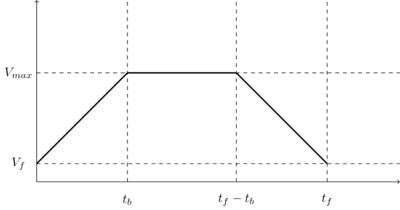

In [2]:
%%tikz -s 400,400
\draw[->] (0,0) -- (10,0);
\draw[->] (0,0) -- (0,5);

\draw[line width=1] (0,0.5) -- (2.5,3);
\draw[line width=1] (2.5,3) -- (5.5,3);
\draw[line width=1] (5.5,3) -- (8,0.5);
\draw[dashed] (0,0.5) -- (10,0.5);
\draw[dashed] (0,3) -- (10,3);
\draw[dashed] (2.5,0) -- (2.5,5);
\draw[dashed] (5.5,0) -- (5.5,5);
\draw[dashed] (8,0) -- (8,5);

\draw (-0.5, 0.5) node {$V_{f}$};
\draw (-0.5, 3) node {$V_{max}$};
\draw (2.5, -0.5) node {$t_b$};
\draw (5.5, -0.5) node {$t_f-t_b$};
\draw (8, -0.5) node {$t_f$};

The time to accelerate from $V_f$ to $V_{max}$ is $t_b = \frac{V-V_f}{a}$. We can substitute this into newtons first equation of motion as follows.

\begin{align}
d &= Vt_b - \frac{1}{2}a{t_b}^2 \\
  &= V\Big(\frac{V-V_f}{a}\Big) - \frac{1}{2}a\Big(\frac{V-V_f}{a}\Big)^2 \\
  &= \Big(\frac{V^2-VV_f}{a}\Big) - \Big(\frac{a(V-V_f)^2}{2a^2}\Big) \\
  &= \Big(\frac{2V^2-2VV_f}{2a}\Big) - \Big(\frac{V^2-2VV_f+{V_f}^2}{2a}\Big) \\
  &= \frac{2V^2-2VV_f - V^2 + 2VV_f - {V_f}^2}{2a} \\
d &= \frac{V^2-{V_f}^2}{2a} \\
\end{align}

For example, if you're at starting at $V_f=0.2\frac{m}{s}$, and you're ramping up to $V=0.5\frac{m}{s}$, and you're acceleration is fixed at the $a=2\frac{m}{s^2}$, the distance you'll need to do that is $d = \frac{0.5 - 0.2}{2*2} = 0.075m$

## Code that proves it

In [3]:
# dependencies and global setup
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3, linewidth=100)

LOG_LVL = 2
   
def debug(*args):
    if LOG_LVL <= 0:
        print(*args)

def info(*args):
    if LOG_LVL <= 1:
        print(*args)
        
def warning(*args):
    if LOG_LVL <= 2:
        print(*args)
        
def log(*args):
    if LOG_LVL < 100:
        print(*args)


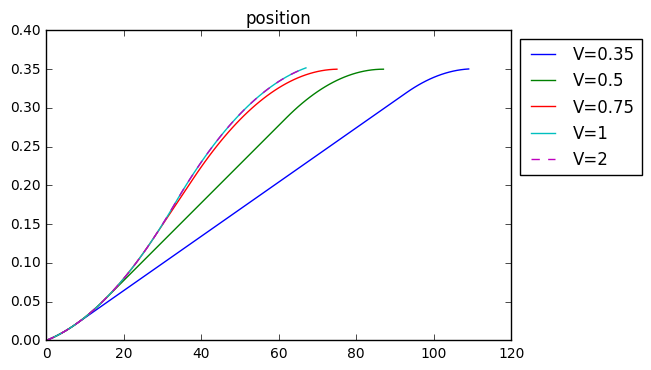

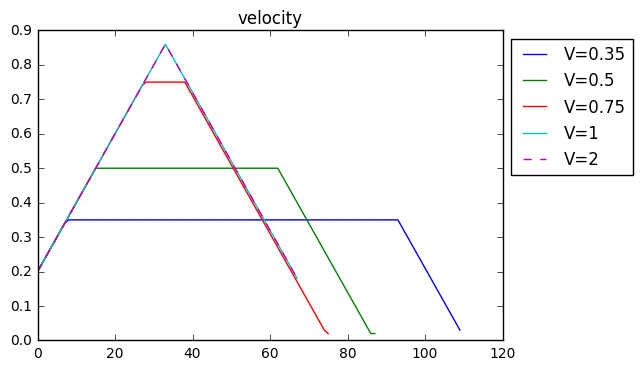

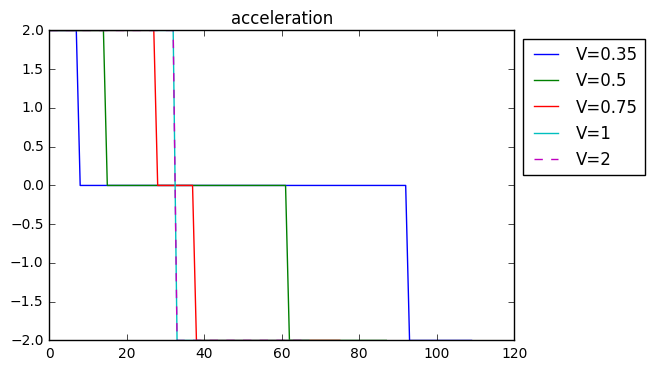

In [4]:
def profile(V0, Vf, Vmax, d, A, buffer=3e-3):
    v = V0
    x = 0
    a = A
    vs = [v]
    xs = [x]
    a_s = [a]
    
    dt = 0.01
    while x < d:
        x = x + v*dt + a*dt*dt/2.0
        v = v + a*dt
        ramp_d = (v*v+ - Vf*Vf) / (2.0*A)
        if (d-x) < ramp_d + buffer:
            a = -A
        elif v < Vmax:
            a = A
        else:
            a = 0
        
        if v > Vmax:
            v = Vmax
        elif v < Vf:
            v = Vf
                
        xs.append(x)
        vs.append(v)
        a_s.append(a)
        
    return xs, vs, a_s

def graph(title, idx):
    plt.figure()
    plt.title(title)
    Vs = [0.35, 0.5, 0.75, 1, 2]
    Vf = 0.02
    V0 = 0.2
    d = 0.35
    a = 2
    for V in Vs:    
        results  = profile(V0, Vf, V, d, a)
        vs = results[1]
        if V == 2: # make V=2 dashed so we can see it over V=1
            plt.plot(results[idx], label='V={}'.format(V), linestyle='dashed')
        else:
            plt.plot(results[idx], label='V={}'.format(V))
        plt.legend(bbox_to_anchor=(1, 1), loc=2)

graph("position", 0)
graph("velocity", 1)
graph("acceleration", 2)
plt.show()

## General Form Trajectory Planning

Let's start out with a generating trajectories that are not time optimal, but rely on specifying the final time $v_f$. For smartmouse, our state space is $[x, y, \theta]$, and a turn can be defined as starting at a point $[x_0, y_0, \theta_0]$ and going to $[x_f, y_f, \theta_0]$. Of course, we also want to specify the velocities at these point, $[\dot{x}_0, \dot{y}_0,\dot{\theta}_0]$ and $[\dot{x}_f, \dot{y}_f,\dot{\theta}_f]$. We have four constraints, so if we want to fit a smooth polynomial to those points we need a 4th order polynomial.

$$q(t) = a_0 + a_1t + a_2t^2 + a_3t^3$$
$$\dot{q}(t) = a_1 + 2a_2t + 3a_3t^2$$

If we sub in our constraints, we get the following system of equations.

\begin{align}
q(0) &= a_0 \\
\dot{q}(0) &= a_1 \\
q(t_f) &= a_0 + a_1t_f + a_2{t_f}^2 + a_3{t_f}^3\\
\dot{q}(t_f) &= a_1 + 2a_2t_f + 3a_3{t_f}^2\\
\end{align}

In matrix form that looks like:
\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
1 & t_f & t_f^2 & t_f^3 \\
0 & 1 & 2t_f & 3t_f^2 \\
\end{bmatrix}
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
\end{bmatrix} =
\begin{bmatrix}
q(0) \\
\dot{q}(0) \\
q(t_f) \\
\dot{q}(t_f) \\
\end{bmatrix}
\end{equation}

It can be shown that the matrix on the left is invertable, so long as $t_f-t_0 > 0$. So we can invert and solve this equation and get all the $a$ coefficients. We can then use this polynomial to generate the $q(t)$ and $\dot{q}(t)$ -- our trajectory.

In [5]:
def simple_traj_solve(q_0, q_f, q_dot_0, q_dot_t_f, t_f):
    # Example: you are a point in space (one dimension) go from rest at the origin to at rest at (0.18, 0, 0) in 1 second
    q_0 = np.array([0])
    q_dot_0 = np.array([0])
    q_t_f = np.array([0.18])
    q_dot_t_f = np.array([0])

    b = np.array([q_0, q_dot_0, q_t_f, q_dot_t_f])
    a = np.array([[1,0,0,0],[0,1,0,0],[1, t_f, pow(t_f,2),pow(t_f,3)],[0,1,2*t_f,3*pow(t_f,2)]])
    log(a, b)
    coeff = np.linalg.solve(a, b)
    log(coeff)
    
    return coeff

simple_traj_info = (0, 0, 0.18, 0, 1)
simple_traj_coeff = simple_traj_solve(*simple_traj_info)

[[1 0 0 0]
 [0 1 0 0]
 [1 1 1 1]
 [0 1 2 3]] [[ 0.  ]
 [ 0.  ]
 [ 0.18]
 [ 0.  ]]
[[ 0.  ]
 [ 0.  ]
 [ 0.54]
 [-0.36]]


Here you can see that the resulting coeffictions are $a_0=0$, $a_1=0$, $a_2=0.54$, $a_0=-0.36$. Intuitively, this says that we're going to have positive acceleration, but our acceleration is going to slow down over time. Let's graph it!

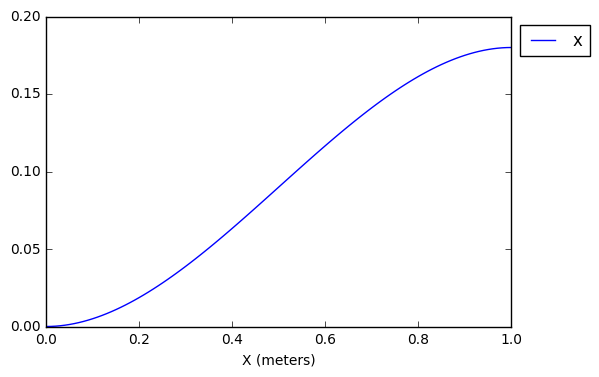

In [6]:
def simple_traj_plot(coeff, t_f):
    dt = 0.01
    ts = np.array([[1, t, pow(t,2), pow(t,3)] for t in np.arange(0, t_f+dt,  dt)])
    qs = ts@coeff
    plt.plot(ts[:,1], qs, label="x")
    plt.xlabel("time (seconds)")
    plt.xlabel("X (meters)")
    plt.legend(bbox_to_anchor=(1,1), loc=2)
    plt.show()

simple_traj_plot(simple_traj_coeff, simple_traj_info[-1])

**ooooooooooh so pretty**

Let's try another example, now with our full state space of $[x, y, \theta]$.

[[ 0.09   0.09   0.   ]
 [ 0.     0.     0.   ]
 [ 0.54   0.27  -4.712]
 [-0.36  -0.18   3.141]]


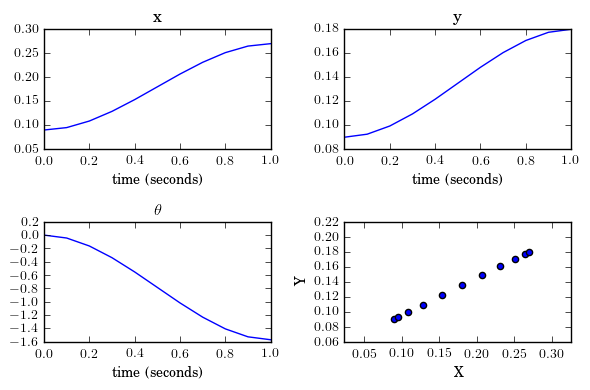

In [7]:
def no_dynamics():
    # In this example, we go from (0.18, 0.09, 0) to (0.27,0.18, -1.5707). Our starting and ending velocities are zero
    q_0 = np.array([0.09,0.09,0])
    q_dot_0 = np.array([0,0,0])
    q_f = np.array([0.27,0.18,-1.5707])
    q_dot_f = np.array([0,0,0])
    t_f = 1

    b = np.array([q_0, q_dot_0, q_f, q_dot_f])
    a = np.array([[1,0,0,0],[0,1,0,0],[1, t_f, pow(t_f,2),pow(t_f,3)],[0,1,2*t_f,3*pow(t_f,2)]])
    coeff = np.linalg.solve(a, b)
    log(coeff)

    dt = 0.1
    ts = np.array([[1, t, pow(t,2), pow(t,3)] for t in np.arange(0, t_f+dt,  dt)])
    qs = ts@coeff

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.gca().set_adjustable("box")
    plt.subplot(221)
    plt.plot(ts[:,1], qs[:,0])
    plt.xlabel("time (seconds)")
    plt.title("x")
    plt.subplot(222)
    plt.plot(ts[:,1], qs[:,1])
    plt.xlabel("time (seconds)")
    plt.title("y")
    plt.subplot(223)
    plt.plot(ts[:,1], qs[:,2])
    plt.xlabel("time (seconds)")
    plt.title(r"$\theta$")
    plt.subplot(224)
    plt.scatter(qs[:,0], qs[:,1])
    plt.axis('equal')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()
    
no_dynamics()

Well, they are smooth, but these are not possible to execute! The robot cannot simply translate sideways.

# Trajectory Planning With a Simple Dynamics Model

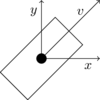

In [8]:
%%tikz -s 100,100

\draw [rotate around={-45:(0,0)}] (-.5,-1) rectangle (0.5,1);
\filldraw (0,0) circle (0.125);

\draw [->] (0,0) -- (0,1.5);
\draw [->] (0,0) -- (1.5,0);
\draw [->] (0,0) -- (1.5,1.5);
\draw (1.2, -0.2) node {$x$};
\draw (-0.2, 1.2) node {$y$};
\draw (1, 1.2) node {$v$};


We need to change our constraints to the system of equations. Specifically, we need our dynamics model. For now, let's assume a simplified car model.

$$ \dot{x} = v\cos(\theta) $$
$$ \dot{y} = v\sin(\theta) $$

This basically claims that for any instant in time the robot is moving a constant velocity along $\theta$. This isn't very accurate, but let's just start with that since the real dynamics of our robot are more complex.

First we will bring in the constraints from before. We must satisfy specific initial and final positions in $[x, y, \theta]$. I've used new letters for cofficients to avoid confusion.

\begin{align}
x_0 &= c_0 + c_1(0) + c_2(0)^2 + c_3(0)^3 + c_3(0)^4 + c_3(0)^5 \\
y_0 &= d_0 + d_1(0) + d_2(0)^2 + d_3(0)^3 + d_3(0)^4 + d_3(0)^5 \\
x_{t_f} &= c_0 + c_1(t_f) + c_2(t_f)^2 + c_3(t_f)^3 + c_3(t_f)^4 + c_3(t_f)^5 \\
y_{t_f} &= d_0 + d_1(t_f) + d_2(t_f)^2 + d_3(t_f)^3 + d_3(t_f)^4 + d_3(t_f)^5 \\
\end{align}

Notice here we have 12 unknowns, $c_0 \dots c_5$ and $d_0 \dots d_5$. So we're gonna need more equations for there to be a unique solution. Also notice we haven't defined any constraints related to our dynamics model. That would be a good place to get our other equations!

First, we want to be able to specify initial velocity $v_0$ and final velocity $v_{t_f}$. It is easlier to just constrain $\dot{x}_0$,  $\dot{y}_0$,  $\dot{x}_{t_f}$,  $\dot{y}_{t_f}$. So if we want to specify that we start facing $\tfrac{\pi}{2}$ going 1m/s, we'd just specify $cos(\tfrac{\pi}{2})$ for $\dot{x}_0$ and $sin(\tfrac{\pi}{2})$ for $\dot{y}_0$.

\begin{align}
\dot{x}_0 &= c_1 \\
\dot{y}_0 &= d_1 \\
\dot{x}_{t_f} &= (0)c_0 + (1)c_1 + 2t_fc_2 + 3{t_f}^2c_3 + 4{t_f}^3c_4 + 5{t_f}^4c_5 \\
\dot{y}_{t_f} &= (0)d_0 + (1)d_1 + 2t_fd_2 + 3{t_f}^2d_3 + 4{t_f}^3d_4 + 5{t_f}^4d_5
\end{align}

Let's also make sure x and y components obey trigonometry.

\begin{align}
  v\cos(\theta)\sin(\theta) + v\cos(\theta)\sin(\theta) &= v\sin(2\theta) \\
  \dot{x}\sin(\theta) + \dot{y}\sin(\theta) &= v\sin(2\theta)
\end{align}

We can get two equations out of this by specifying initial and final velocities

\begin{align}
v_0\sin(2\theta_0) &= \dot{x}_0\sin(\theta_0) + \dot{y}_0\cos(\theta_0) \\
v_{t_f}\sin(2\theta_{t_f}) &= \dot{x}_{t_f}\sin(\theta_{t_f}) + \dot{y}_{t_f}\cos(\theta_{t_f})
\end{align}

We should write out the full form though, to make things in terms of our coefficients.

\begin{align}
v(0)\sin(2\theta_0) &= \Big[c_1 + 2(0)c_2 + 3(0)^2c_3 + 4(0)^3c_4 + 5(0)^4c_5\Big]\sin(\theta_0) + \Big[d_1 + 2(0)d_2 + 3(0)^2d_3 + 4(0)^3d_4 + 5(0)^4d_5\Big]\cos(\theta_0) \\
v(0)\sin(2\theta_0) &= \sin(\theta_0)c_1 + \cos(\theta_0)d_1
\end{align}

\begin{align}
v(t_f)\sin(2\theta_{t_f}) &= \Big[c_1 + 2(t_f)c_2 + 3(t_f)^2c_3 + 4(t_f)^3c_4\ + 5(t_f)^4c_5\Big]\sin(\theta_{t_f}) + \Big[d_1 + 2(t_f)d_2 + 3(t_f)^2d_3 + 4(t_f)^3d_4 + 5(t_f)^4d_5\Big]\cos(\theta_{t_f}) \\
v(t_f)\sin(2\theta_{t_f}) &= \sin(\theta_{t_f})c_1 + 2\sin(\theta_{t_f})t_fc_2 + 3\sin(\theta_{t_f}){t_f}^2c_3 + 4\sin(\theta_{t_f}){t_f}^3c_4  + 5\sin(\theta_{t_f}){t_f}^4c_5 + \cos(\theta_{t_f})d_1 + 2\cos(\theta_{t_f})t_fd_2 + 3\cos(\theta_{t_f}){t_f}^2d_3 + 4\cos(\theta_{t_f}){t_f}^3d_4 + 5\cos(\theta_{t_f}){t_f}^4d_5 \\
\end{align}

The last two equations constrains the robot from moving in any direction other than its heading. Of course it must relate $\dot{x}$ to $\dot{y}$. Still not totally sure how we got this equation so I'm just copying it from some slides$\dots$. However you can plug in some example values and check. For instance translating sideways violates this equation: set $\dot{x}=1$, $\dot{y}=0$, $v=1$, $\theta=\tfrac{\pi}{2}$.

\begin{align}
v\cos(\theta)\sin(\theta) - v\cos(\theta)\sin(\theta) &= 0 \\
v\cos(\theta)\sin(\theta) - v\sin(\theta)\cos(\theta) &= 0 \\
\dot{x}\sin(\theta) - \dot{y}\cos(\theta) &= 0
\end{align}

and again written out fully in terms of our coefficients

\begin{align}
\Big[c_1 + 2(0)c_2 + 3(0)^2c_3 + 4(0)^3c_4 + 5(0)^4c_5\Big]\sin(\theta_0) - \Big[d_1 + 2(0)d_2 + 3(0)^2d_3 + 4(0)^3d_4 + 5(0)^4d_5\Big]\cos(\theta_0) &= 0 \\
\sin(\theta_0)c_1 - \cos(\theta_0)d_1 &= 0
\end{align}

\begin{align}
\Big[c_1 + 2(t_f)c_2 + 3(t_f)^2c_3 + 4(t_f)^3c_4 + 5(t_f)^4c_5\Big]\sin(\theta_{t_f}) - \Big[d_1 + 2(t_f)d_2 + 3(t_f)^2d_3 + 4(t_f)^3d_4 + 5(t_f)^4d_5\Big]\cos(\theta_{t_f}) &= 0 \\
\sin(\theta_{t_f})c_1 + 2\sin(\theta_{t_f})t_fc_2 + 3\sin(\theta_{t_f}){t_f}^2c_3 + 4\sin(\theta_{t_f}){t_f}^3c_4  + 5\sin(\theta_{t_f}){t_f}^4c_5 - \cos(\theta_{t_f})d_1 - 2\cos(\theta_{t_f})t_fd_2 - 3\cos(\theta_{t_f}){t_f}^2d_3 - 4\cos(\theta_{t_f}){t_f}^3d_4 - 5\cos(\theta_{t_f}){t_f}^4d_5 &= 0
\end{align}

Ok, that should work. Now let's write it out in matrix form. We use $c$ and $s$ to shorten $\sin$ and $\cos$.

\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & s(\theta_0) & 0 & 0 & 0 & 0 & 0 & c(\theta_0) & 0 & 0 & 0 & 0\\
0 & s(\theta_0) & 0 & 0 & 0 & 0 & 0 & -c(\theta_0) & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
1 & t & {t_f}^2 & {t_f}^3 & {t_f}^4 & {t_f}^5 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & t_f & {t_f}^2 & {t_f}^3 & {t_f}^4 & {t_f}^5 \\
0 & s(\theta_{t_f}) & 2s(\theta_{t_f})t_f & 3s(\theta_{t_f}){t_f}^2 & 4s(\theta_{t_f}){t_f}^3 & 5s(\theta_{t_f}){t_f}^4 & 0 & c(\theta_{t_f}) & 2c(\theta_{t_f}){t_f} & 3c(\theta_{t_f}){t_f}^2 & 4c(\theta_{t_f}){t_f}^3 & 5c(\theta_{t_f}){t_f}^4 \\
0 & s(\theta_{t_f}) & 2s(\theta_{t_f})t_f & 3s(\theta_{t_f}){t_f}^2 & 4s(\theta_{t_f}){t_f}^3 & 5s(\theta_{t_f}){t_f}^4 & 0 & -c(\theta_{t_f}) & -2c(\theta_{t_f}){t_f} & -3c(\theta_{t_f}){t_f}^2 & -4c(\theta_{t_f}){t_f}^3 & -5c(\theta_{t_f}){t_f}^4 \\
0 & 1 & 2t_f & 3{t_f}^2 & 4{t_f}^3 & 5{t_f}^4 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 2t_f & 3{t_f}^2 & 4{t_f}^3 & 5{t_f}^4
\end{bmatrix}
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 \\
c_4 \\
c_5 \\
d_0 \\
d_1 \\
d_2 \\
d_3 \\
d_4 \\
d_5
\end{bmatrix} =
\begin{bmatrix}
x_0 \\
y_0 \\
0 \\
v_0s(2\theta_0) \\
c(\theta_0)v_0 \\
s(\theta_0)v_0 \\
x_{t_f} \\
y_{t_f} \\
0 \\
v_{t_f}s(2\theta_{t_f}) \\
c(\theta_{t_f})v_{t_f} \\
s(\theta_{t_f})v_{t_f} \\
\end{bmatrix}
\end{equation}

In [9]:
# Let's solve this in code like we did before
def plot_vars(traj_plan):
    dt = 0.001
    T = np.arange(0, traj_plan.get_t_f()+dt, dt)
    xts = np.array([[1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5), 0, 0, 0, 0, 0, 0] for t in T])
    xdts = np.array([[0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4), 0, 0, 0, 0, 0, 0] for t in T])
    yts = np.array([[0, 0, 0, 0, 0, 0, 1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5)] for t in T])
    ydts = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4)] for t in T])
    xs = xts@traj_plan.get_coeff()
    ys = yts@traj_plan.get_coeff()
    xds = xdts@traj_plan.get_coeff()
    yds = ydts@traj_plan.get_coeff()
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('axes.formatter', useoffset=False)
    plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    plt.plot(T, xs, linewidth=3)
    plt.xlabel("time (seconds)")
    plt.title("X")

    plt.subplot(222)
    plt.plot(T, ys, linewidth=3, color='r')
    plt.xlabel("time (seconds)")
    plt.title("Y")

    plt.subplot(223)
    plt.plot(T, xds, linewidth=3, color='g')
    plt.xlabel("time (seconds)")
    plt.title("$\dot{x}$")
    plt.tight_layout()
    
    plt.subplot(224)
    plt.plot(T,yds, linewidth=3, color='y')
    plt.xlabel("time (seconds)")
    plt.title("$\dot{y}$")
    plt.tight_layout()
    plt.show()
    
def plot_traj(traj_plan):
    dt = 0.01
    T = np.arange(0, traj_plan.get_t_f()+dt, dt)
    xts = np.array([[1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5), 0, 0, 0, 0, 0, 0] for t in T])
    yts = np.array([[0, 0, 0, 0, 0, 0, 1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5)] for t in T])
    xs = xts@traj_plan.get_coeff()
    ys = yts@traj_plan.get_coeff()
    
    plt.figure(figsize=(10, 10))
    W = 4
    plt.scatter(xs, ys, marker='.', linewidth=0, c=T)
    plt.xlim(0, W * 0.18)
    plt.ylim(0, W * 0.18)
    plt.xticks(np.arange(W+1)*0.18)
    plt.yticks(np.arange(W+1)*0.18)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajectory")
    plt.suptitle("time goes from blue to red")
    plt.grid(True)
    
    plt.show()

In [10]:
from math import sin, cos, pi

class TrajPlan:
    
    def solve(self, q_0, v_0, q_t_f, v_f, t_f):
        A = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                      [0, sin(q_0[2]), 0, 0, 0, 0, 0, cos(q_0[2]), 0, 0, 0, 0],
                      [0, sin(q_0[2]), 0, 0, 0, 0, 0, -cos(q_0[2]), 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [1, t_f, pow(t_f,2), pow(t_f,3), pow(t_f,4), pow(t_f,5), 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, t_f, pow(t_f,2), pow(t_f,3), pow(t_f,4), pow(t_f,5)],
                      [0, sin(q_t_f[2]), 2*sin(q_t_f[2])*t_f, 3*sin(q_t_f[2])*pow(t_f,2), 4*sin(q_t_f[2])*pow(t_f,3), 5*sin(q_t_f[2])*pow(t_f,4), 0, cos(q_t_f[2]), 2*cos(q_t_f[2])*t_f, 3*cos(q_t_f[2])*pow(t_f,2), 4*cos(q_t_f[2])*pow(t_f,3), 5*cos(q_t_f[2])*pow(t_f,4)],
                      [0, sin(q_t_f[2]), 2*sin(q_t_f[2])*t_f, 3*sin(q_t_f[2])*pow(t_f,2), 4*sin(q_t_f[2])*pow(t_f,3), 5*sin(q_t_f[2])*pow(t_f,4), 0, -cos(q_t_f[2]), -2*cos(q_t_f[2])*t_f, -3*cos(q_t_f[2])*pow(t_f,2), -4*cos(q_t_f[2])*pow(t_f,3), -5*cos(q_t_f[2])*pow(t_f,4)],
                      [0, 1, 2*t_f, 3*pow(t_f,2), 4*pow(t_f,3), 5*pow(t_f,4), 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1, 2*t_f, 3*pow(t_f,2), 4*pow(t_f,3), 5*pow(t_f,4)],
                     ])
        B = np.array([q_0[0],
                      q_0[1],
                      0,
                      v_0*sin(2*q_0[2]),
                      cos(q_0[2])*v_0,
                      sin(q_0[2])*v_0,
                      q_t_f[0],
                      q_t_f[1],
                      0,
                      v_f*sin(2*q_t_f[2]),
                      cos(q_t_f[2])*v_f,
                      sin(q_t_f[2])*v_f,
                     ])

        rank = np.linalg.matrix_rank(A)

        if rank == A.shape[1]:
            if A.shape[0] == A.shape[1]:
                coeff = np.linalg.solve(A, B)
            else:
                warning("not square, using least squares.".format(A.shape))
                coeff, resid, rank, s = np.linalg.lstsq(A, B)
        else:
            warning("Ranks don't match! {} equations {} variables, using least squares".format(rank, A.shape[1]))
            coeff, resid, rank ,s = np.linalg.lstsq(A, B)

        debug("rank {}".format(rank))
        debug("A: \n{}".format(A))
        debug("coeff: \n{}".format(coeff))
        error = np.sum(np.power(A@coeff - B, 2))
        if error > 1e-10:
            info("These two vectors should be equal! But there is error.")
        info("B is: \n{}".format(B))
        info("A@coeff is: \n{}".format(A@coeff))
        info("RMS Error of solution to equations")
        info(error)
        
        self.coeff = coeff
        self.t_f = t_f
        
    def get_coeff(self):
        return self.coeff
    
    def get_t_f(self):
        return self.t_f

## Example Plots

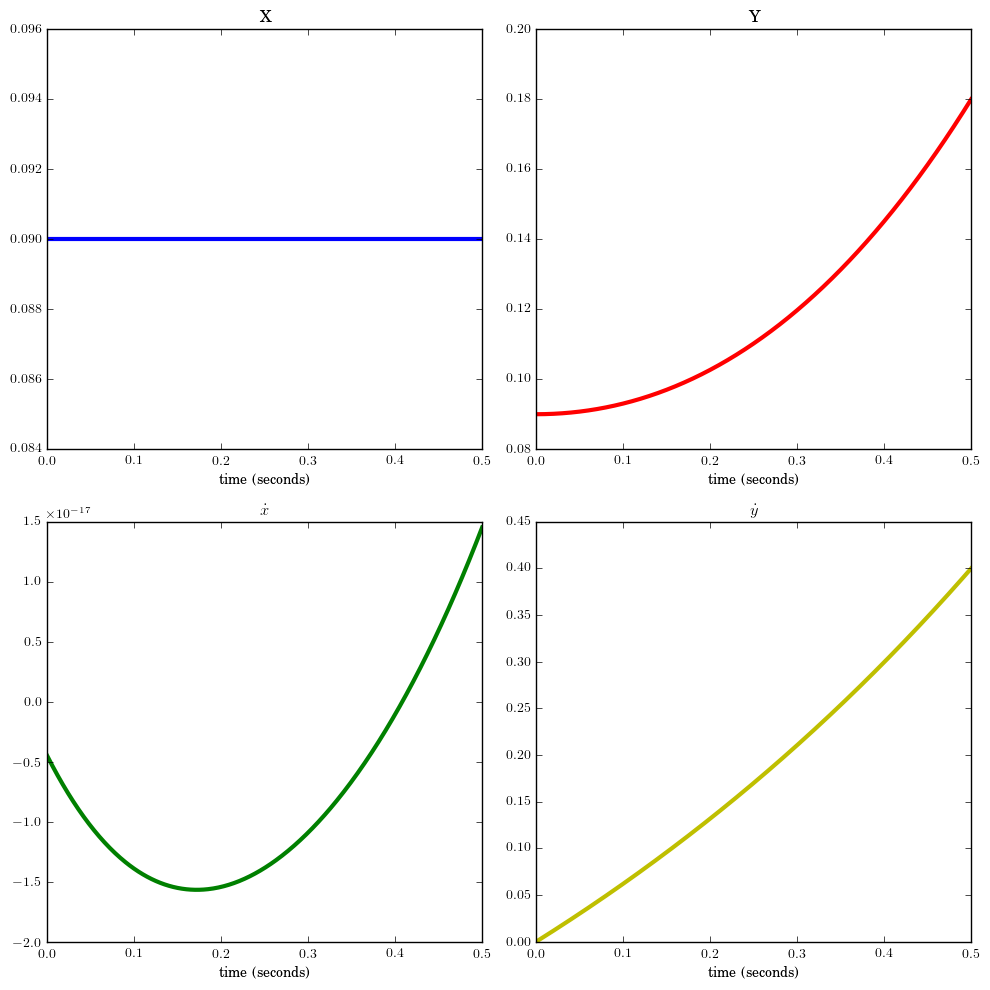

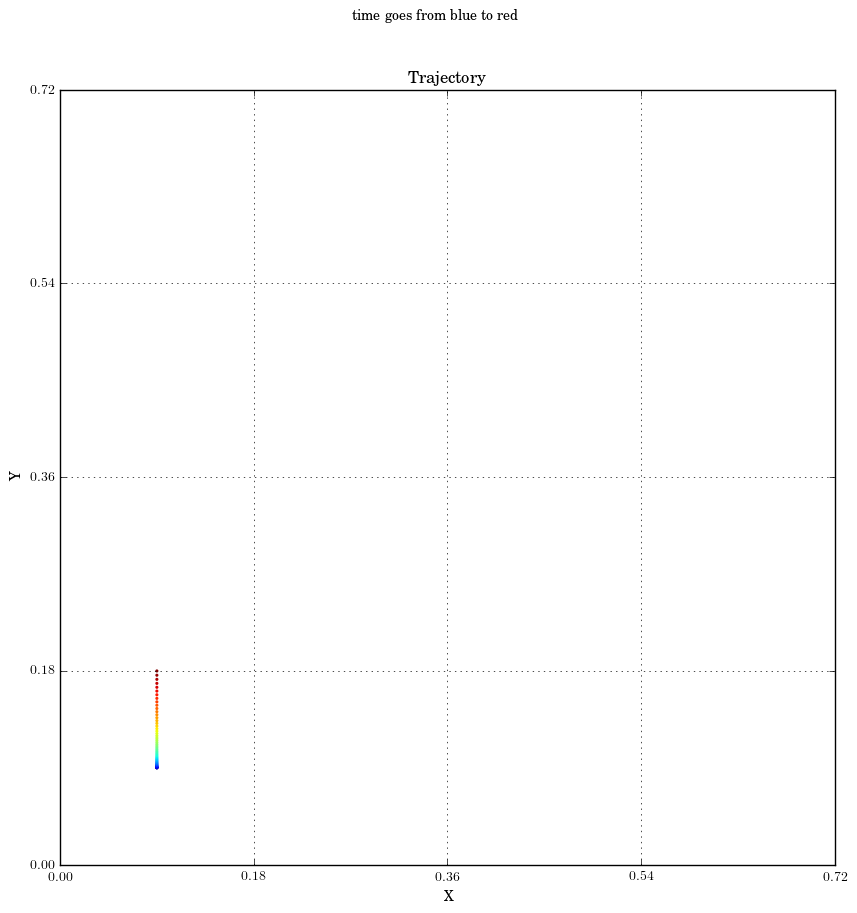

In [11]:
# forward 1 cell, start from rest, end at 40cm/s, do it in .5 seconds
LOG_LVL = 5
fwd_1 = TrajPlan()
fwd_1.solve(q_0=[0.09, 0.09, pi/2], v_0=0, q_t_f=[0.09, 0.18, pi/2], v_f=0.4, t_f=0.5)
plot_vars(fwd_1)
plot_traj(fwd_1)

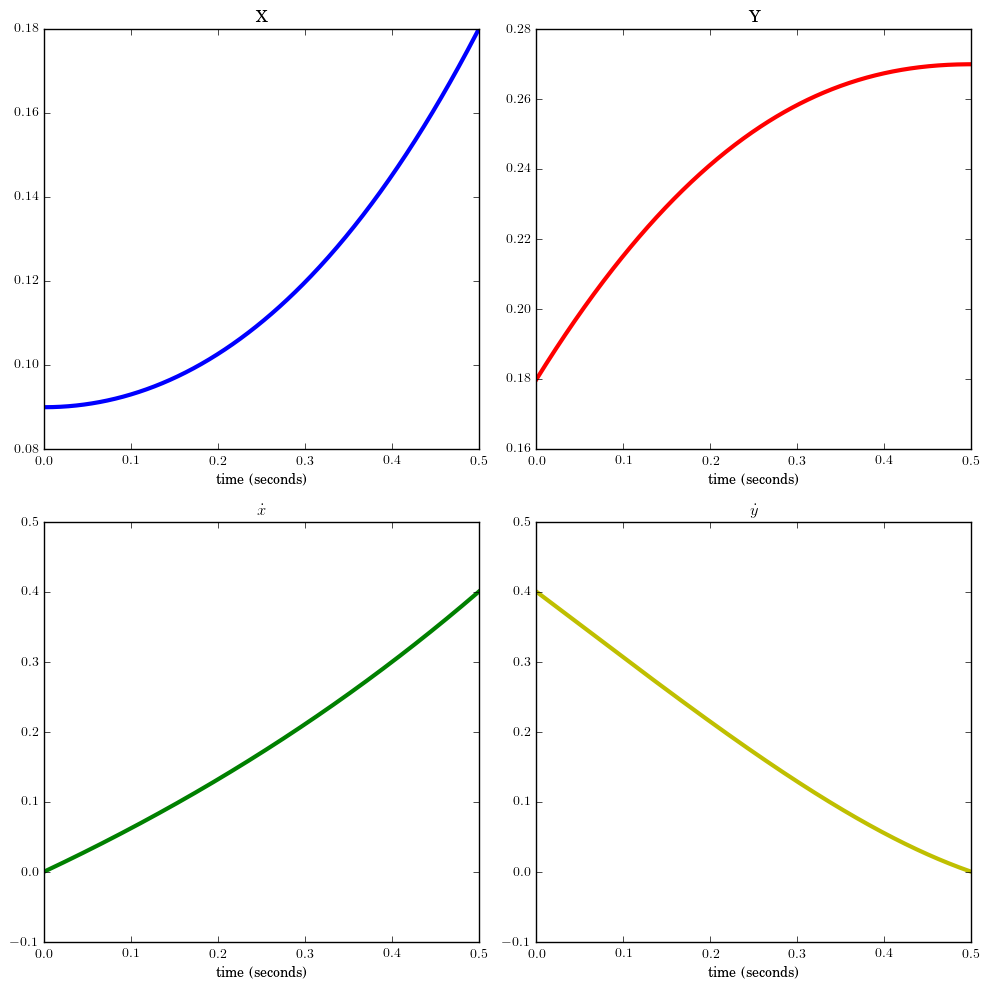

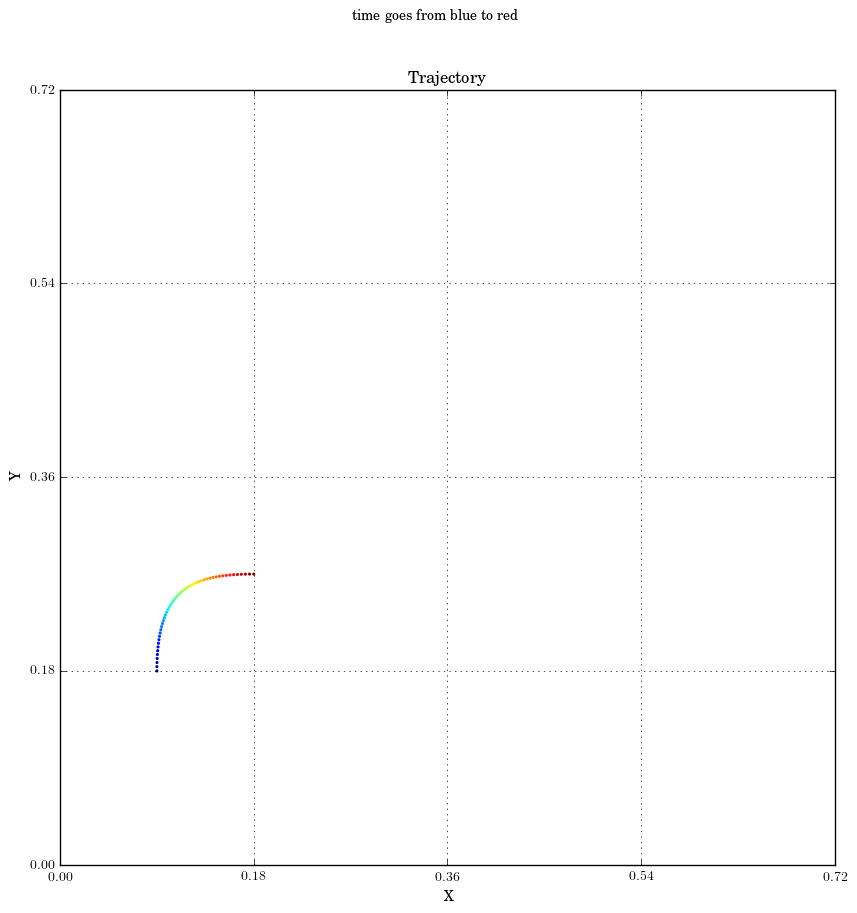

In [12]:
# continue by turning right 90 degrees
LOG_LVL = 5
turn_right = TrajPlan()
turn_right.solve(q_0=[0.09, 0.18, pi/2], v_0=0.4, q_t_f=[0.18, 0.27, 0], v_f=0.4, t_f=0.5)
plot_vars(turn_right)
plot_traj(turn_right)